In [1]:
import torch
from torch import nn, Tensor
import matplotlib.pyplot as plt

Define a 1D Flow (Neural ODE Model)

In [2]:
class Flow(nn.Module):
    def __init__(self, dim: int = 1, h: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim)
        )

    def forward(self, x_t: Tensor, t: Tensor) -> Tensor:
        # Concatenate time and data [t, x]
        return self.net(torch.cat((t, x_t), dim=-1))

    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        # Expand scalar t_start to match batch size
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
        dt = t_end - t_start

        # Midpoint Runge-Kutta (RK2 / "midpoint method")
        v1 = self(x_t, t_start)
        x_mid = x_t + v1 * (dt / 2)
        t_mid = t_start + dt / 2
        v2 = self(x_mid, t_mid)

        return x_t + dt * v2

Training Setup

In [3]:
flow = Flow(dim=1)
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

Training Loop

In [4]:
for _ in range(5000):
    # Placeholder "target" gene expression distribution (replace with real data later)
    x_1 = torch.randn(256, 1) * 0.5 + 2.0  # e.g., gene expression values around 2.0

    # x_0 = Gaussian noise (starting distribution)
    x_0 = torch.randn_like(x_1)

    # Sample random time t in [0, 1]
    t = torch.rand(len(x_1), 1)

    # Linear interpolation: x_t = (1 - t)x_0 + t x_1
    x_t = (1 - t) * x_0 + t * x_1

    # True derivative for linear interpolation: dx/dt = x_1 - x_0
    dx_t = x_1 - x_0

    optimizer.zero_grad()
    loss_fn(flow(x_t, t), dx_t).backward()
    optimizer.step()


Sampling

In [5]:
x = torch.randn(300, 1)  # start from Gaussian noise
n_steps = 20
time_steps = torch.linspace(0, 1, n_steps + 1)

xs = [x.clone()]  # store for visualization
for i in range(n_steps):
    x = flow.step(x, time_steps[i], time_steps[i + 1])
    xs.append(x.clone())



Plot Evolution of Distribution

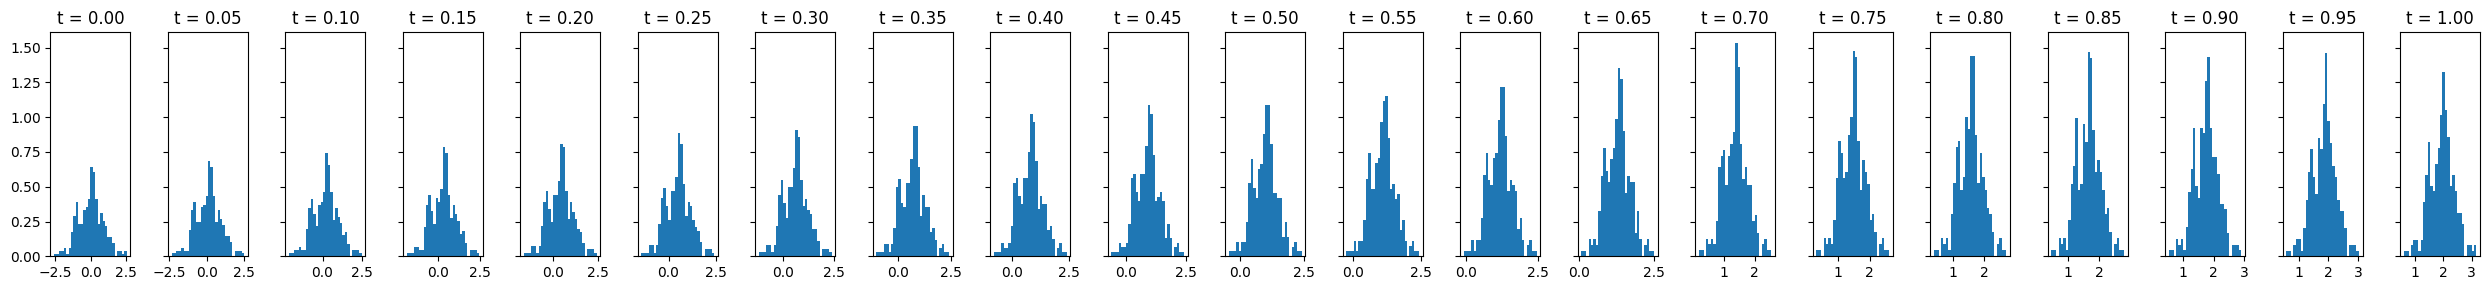

In [6]:
fig, axes = plt.subplots(1, n_steps + 1, figsize=(25, 3), sharey=True)

for i, (ax, x_i) in enumerate(zip(axes, xs)):
    ax.hist(x_i.detach().numpy(), bins=30, density=True)
    ax.set_title(f"t = {time_steps[i]:.2f}")

plt.tight_layout()
plt.show()